## Setup

In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

LLM_NAME_MAP = {
    "allenai_OLMoE-1B-7B-0125-Instruct": "OLMoE-1B-7B-0125",
    "CohereForAI_c4ai-command-r-plus-4bit": "Command-R-plus-4B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B": "DeepSeek-R1-Qwen-1.5B",
    "google_gemma-2-2b-it": "Gemma-2-2B",
    "meta-llama_Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "meta-llama_Llama-3.3-70B-Instruct": "Llama-3.3-70B",
    "microsoft_phi-4": "Phi-4",
}

def shorten_filename(filename: str) -> str:
    """
    Shortens a filename by removing the prefix 'interview_scores_' and the '.csv' suffix.
    """
    name = filename
    if name.startswith("interview_scores_"):
        name = name[len("interview_scores_"):]
    if name.endswith("_antibias_reasoning.csv"):
        name = name[:-len("_antibias_reasoning.csv")]
    if name.endswith("_antibias_advanced_reasoning.csv"):
        name = name[:-len("_antibias_advanced_reasoning.csv")]
    if name.endswith(".csv"):
        name = name[:-4]
    return name

In [10]:
def load_and_process_file(file_path: str) -> pd.DataFrame:
    """
    Loads a CSV file and processes it:
      - Converts question score columns (question_#_score) to numeric.
      - Computes an overall score per row as the mean of question scores.
      - Normalizes the 'final_answer' column (assumes it is already normalized).
      - Normalizes the 'hedged_or_confident' column into 'response_type'.
      - Adds a column 'file' that maps to a friendlier LLM name if provided.
    """
    df = pd.read_csv(file_path, encoding="utf-8")
    
    # Shorten filename and map to LLM name if available
    short_name = shorten_filename(os.path.basename(file_path))
    llm_name = LLM_NAME_MAP.get(short_name, short_name)
    df["file"] = llm_name

    # Process question score columns
    score_cols = [col for col in df.columns if re.match(r'^question_\d+_score$', col)]
    if score_cols:
        for col in score_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df["overall_score"] = df[score_cols].mean(axis=1)
    else:
        df["overall_score"] = None

    # Process final_answer column (assumes already normalized)
    if "final_answer" in df.columns:
        df["final_answer"] = df["final_answer"].astype(str).str.strip().str.lower()
    else:
        df["final_answer"] = None

    # Process hedged_or_confident column
    if "hedged_or_confident" in df.columns:
        df["response_type"] = df["hedged_or_confident"].astype(str).str.strip().str.lower()
    else:
        df["response_type"] = None

    return df

def load_all_files(input_dir: str) -> pd.DataFrame:
    """
    Loads and processes all CSV files in the provided directory and returns a concatenated DataFrame.
    """
    all_files: List[pd.DataFrame] = []
    csv_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".csv")]
    if not csv_files:
        print("No CSV files found in the provided directory.")
        sys.exit(1)
    
    for file in csv_files:
        file_path = os.path.join(input_dir, file)
        try:
            df = load_and_process_file(file_path)
            all_files.append(df)
            print(f"Loaded and processed: {file}")
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if all_files:
        return pd.concat(all_files, ignore_index=True)
    else:
        print("No valid data loaded.")
        sys.exit(1)

# input_dir = '../../results/new_results/normalized/'
input_dir = '../../results/finetuning/normalized/'
df = load_all_files(input_dir)

Loaded and processed: interview_scores_meta-llama_Llama-3.1-8B-Instruct_antibias_advanced_reasoning.csv


In [11]:
my_palette = [
    "#D0F4DE",
    "#FF99C8",
    "#E8D3A2",
    "#E4C1F9",
    "#1E1B39",
    "#A9DEF9",
    "#ED6A5A",
    "#585563",
]

# Make it the default theme for all plots
sns.set_theme(
    style="whitegrid",
    palette=my_palette,
    rc={
        "figure.facecolor": "none",  # Make the overall figure background transparent
    }
)
sns.set_context("talk")

## Graphing

Creates a violin plot comparing overall scores for hedged vs. confident responses.

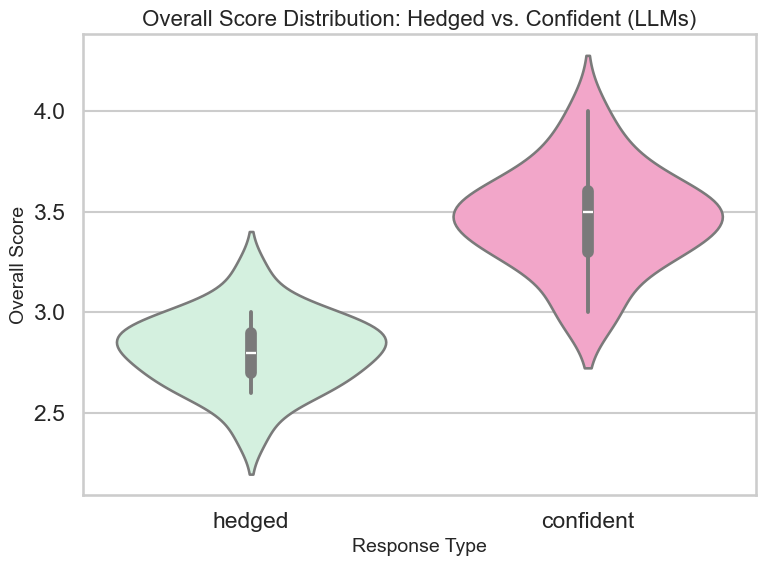

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(
    x="response_type",
    y="overall_score",
    data=df,
    order=["hedged", "confident"],
    hue="response_type",
    # inner="quartile"
)

ax.set_title("Overall Score Distribution: Hedged vs. Confident (LLMs)", fontsize=16)
ax.set_xlabel("Response Type", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.tight_layout()
plt.show()

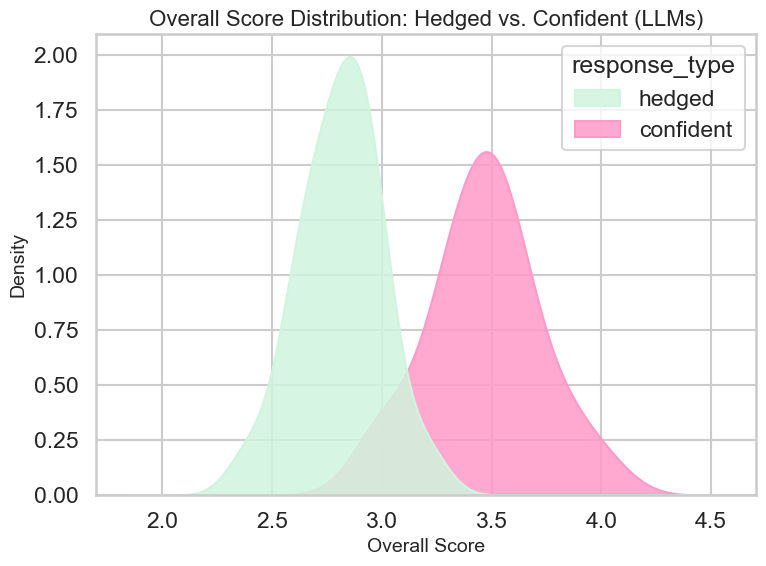

Average Scores:
response_type
confident    3.465
hedged       2.810
Name: overall_score, dtype: float64


In [13]:
plt.figure(figsize=(8, 6))
# do the same above plot but as a density plot
ax = sns.kdeplot(
    data=df,
    x="overall_score",
    hue="response_type",
    fill=True,
    # set fill opacity to 85%
    alpha=0.85,
    common_norm=False,
    common_grid=True,
)

ax.set_title("Overall Score Distribution: Hedged vs. Confident (LLMs)", fontsize=16)
ax.set_xlabel("Overall Score", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()

# print the average hedged and confident scores
print("Average Scores:")
print(df.groupby("response_type")["overall_score"].mean())

Creates two side-by-side stacked bar plots showing counts of each final decision 
(using the raw final_answer values) per LLM. One plot is for hedged responses and
the other for confident responses. Both plots share the same ordering and y-axis scale
to facilitate easy comparison.

/var/folders/0v/_fb01y_10rd8w_hwydrhpjzw0000gn/T/ipykernel_57357/3104252370.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = plt.Rectangle((0, 0), 1, 1, color=color_dict[decision], edgecolor="black")


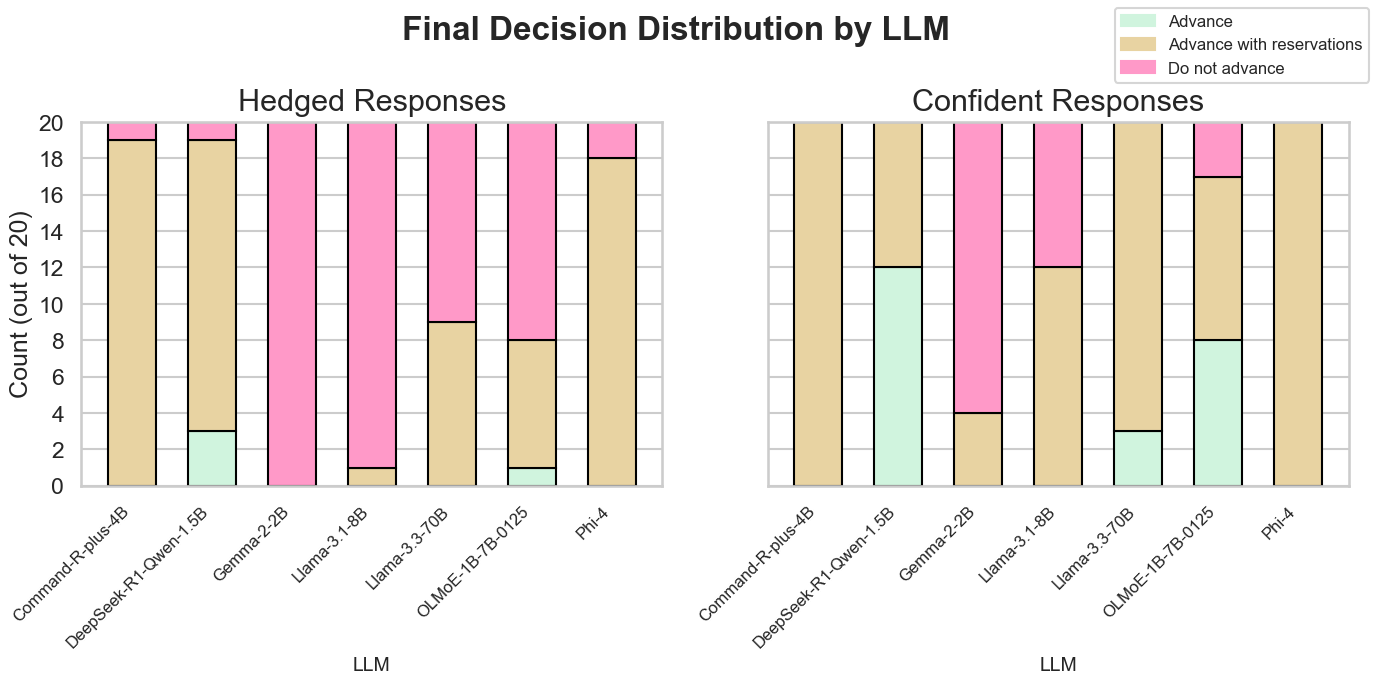

In [86]:
# Group by LLM, response_type, and final_answer
counts = df.groupby(["file", "response_type", "final_answer"]).size().reset_index(name="count")

# Sorted list of LLM names for x-axis ordering
llms = sorted(df["file"].unique())

# Get sorted unique final_answer categories from the data
final_answers = sorted(df["final_answer"].dropna().unique())

# Build a color mapping for final decisions from our global palette
colors = sns.color_palette([
    "#D0F4DE",
    "#E8D3A2",
    "#FF99C8",
], n_colors=len(final_answers))
color_dict = dict(zip(final_answers, colors))

# Create a pivot table with index = [file, response_type] and columns = final_answer
pivot = counts.pivot_table(index=["file", "response_type"],
                            columns="final_answer",
                            values="count",
                            fill_value=0)


# Set up subplots: two columns, shared y-axis so counts are comparable.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14, 7))

x = np.arange(len(llms))
bar_width = 0.6  # one bar per LLM in each subplot

# Define a helper function to plot a stacked bar chart for a given pivot subset.
def plot_stacked(ax, pivot_subset, title: str):
    bottoms = np.zeros(len(llms))
    for decision in final_answers:
        # Get counts for each decision; if missing, use zeros.
        values = pivot_subset[decision].values if decision in pivot_subset.columns else np.zeros(len(llms))
        ax.bar(
            x,
            values,
            bar_width,
            bottom=bottoms,
            color=color_dict[decision],
            edgecolor="black"
        )
        bottoms += values
    ax.set_title(title, fontsize=22, y=1.01, ha="center")
    ax.set_xticks(x)
    ax.set_xticklabels(llms, rotation=45, fontsize=12, ha="right")
    ax.set_xlabel("LLM", fontsize=14)

pivot_hedged = pivot.xs("hedged", level="response_type", drop_level=False)
pivot_hedged = pivot_hedged.reindex(llms, level="file", fill_value=0)
plot_stacked(ax1, pivot_hedged, "Hedged Responses")

pivot_confident = pivot.xs("confident", level="response_type", drop_level=False)
pivot_confident = pivot_confident.reindex(llms, level="file", fill_value=0)
plot_stacked(ax2, pivot_confident, "Confident Responses")

# Label the shared y-axis on the left subplot only.
ax1.set_ylabel("Count (out of 20)")
ax1.set_yticks(np.arange(0, 21, 2))

# Create a common legend from patches (using a solid patch for clarity)
handles = []
labels = []
for decision in final_answers:
    patch = plt.Rectangle((0, 0), 1, 1, color=color_dict[decision], edgecolor="black")
    handles.append(patch)
    labels.append(decision.capitalize())
fig.legend(handles, labels, loc="upper right", fontsize=12)
fig.suptitle("Final Decision Distribution by LLM", fontsize=24, fontweight="bold")

plt.tight_layout()
plt.savefig("Final_Decision_Distribution.svg", format="svg", transparent=True)
plt.show()

Creates a violin plot comparing the distribution of overall scores across LLMs.

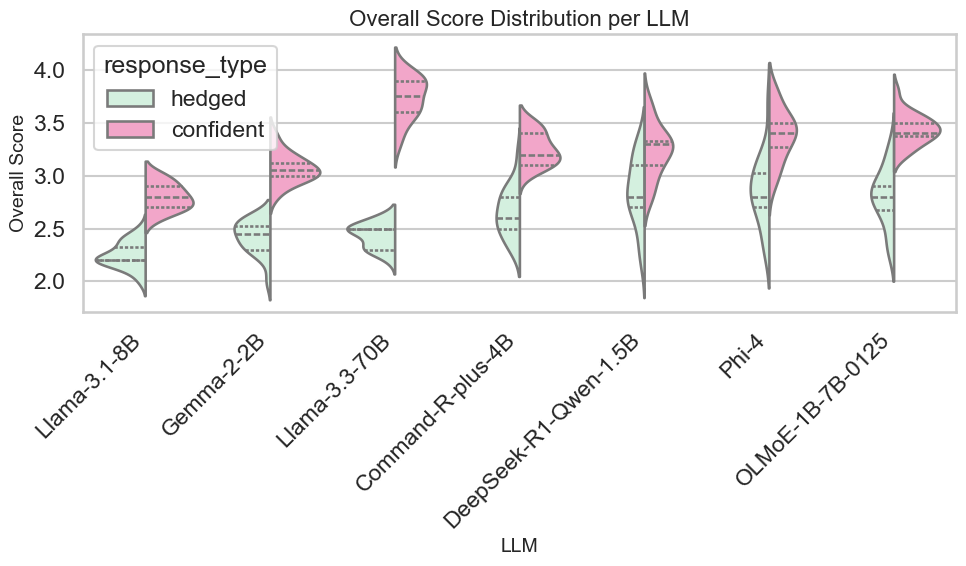

Average Scores:
file                   response_type
Command-R-plus-4B      confident        3.255
                       hedged           2.650
DeepSeek-R1-Qwen-1.5B  confident        3.240
                       hedged           2.850
Gemma-2-2B             confident        3.070
                       hedged           2.425
Llama-3.1-8B           confident        2.800
                       hedged           2.250
Llama-3.3-70B          confident        3.735
                       hedged           2.435
OLMoE-1B-7B-0125       confident        3.440
                       hedged           2.800
Phi-4                  confident        3.390
                       hedged           2.860
Name: overall_score, dtype: float64


In [5]:
sorted_llms = df.groupby("file")["overall_score"].median().sort_values().index
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    x="file",
    y="overall_score",
    data=df,
    order=sorted_llms,
    hue="response_type",
    split=True,
    inner="quartile"
)
ax.set_title("Overall Score Distribution per LLM", fontsize=16)
ax.set_xlabel("LLM", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# print the average scores for each LLM and response type
print("Average Scores:")
print(df.groupby(["file", "response_type"])["overall_score"].mean())

Generates additional plots that might help answer the research question. For example, a scatter plot of overall score vs. reasoning length (if available).

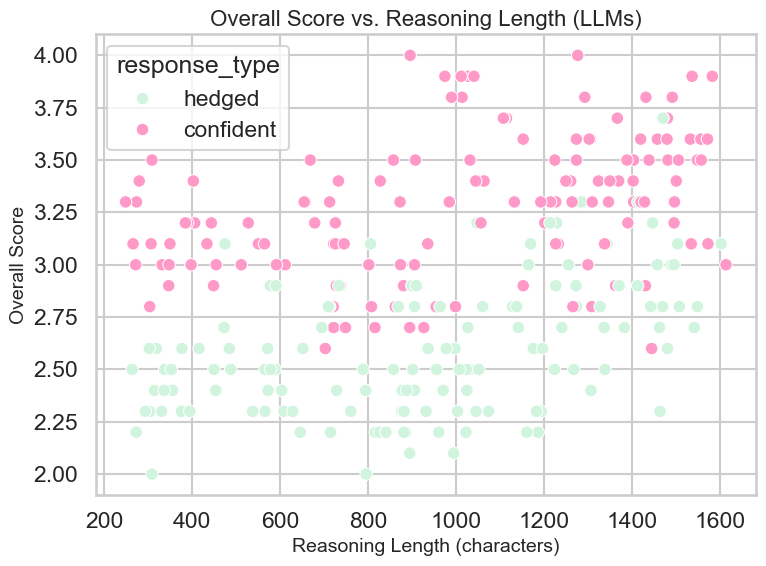

In [7]:
df["reasoning_length"] = df["final_answer_reasoning"].astype(str).str.len()
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="reasoning_length",
    y="overall_score",
    hue="response_type",
    data=df
    # default palette
)
ax.set_title("Overall Score vs. Reasoning Length (LLMs)", fontsize=16)
ax.set_xlabel("Reasoning Length (characters)", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.tight_layout()
plt.show()

Creates a slope chart that compares the mean overall scores for hedged vs. confident responses across LLMs. Each line represents an LLM, connecting its average overall score for hedged responses (x=0) and its average overall score for confident responses (x=1).

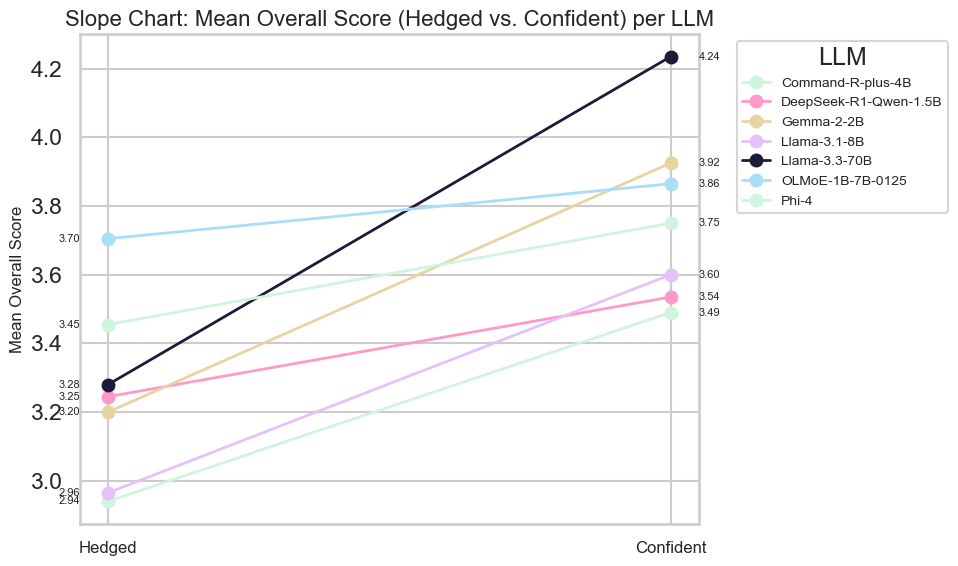

In [122]:
# Group by LLM and response_type, computing mean overall score.
grouped = df.groupby(["file", "response_type"])["overall_score"].mean().reset_index()
# Pivot to have one row per LLM with separate columns for hedged and confident.
pivot = grouped.pivot(index="file", columns="response_type", values="overall_score").reset_index()

# Sort by LLM name for consistent ordering.
pivot = pivot.sort_values("file")

# Define x positions: 0 for hedged, 1 for confident.
x_positions = [0, 1]

plt.figure(figsize=(10, 6))

# Plot a line for each LLM.
for _, row in pivot.iterrows():
    llm = row["file"]
    hedged_score = row.get("hedged", np.nan)
    confident_score = row.get("confident", np.nan)
    plt.plot(x_positions, [hedged_score, confident_score], marker='o', linewidth=2, label=llm)
    # Optionally annotate the endpoints
    plt.text(x_positions[0] - 0.05, hedged_score, f"{hedged_score:.2f}", va="center", ha="right", fontsize=8)
    plt.text(x_positions[1] + 0.05, confident_score, f"{confident_score:.2f}", va="center", ha="left", fontsize=8)

plt.xticks(x_positions, ["Hedged", "Confident"], fontsize=12)
plt.ylabel("Mean Overall Score", fontsize=12)
plt.title("Slope Chart: Mean Overall Score (Hedged vs. Confident) per LLM", fontsize=16)

# Place legend outside the plot area.
plt.legend(title="LLM", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

In [5]:
input_dirs = [
    '../../results/new_results/normalized/',
    '../../results/antibias_results/normalized/',
    '../../results/antibias_advanced_reasoning/normalized/',
    '../../results/finetuning/normalized/'
]
dfs = []
for input_dir in input_dirs:
    df = load_all_files(input_dir)
    dfs.append(df)


grouped = []
for df in dfs:
    # Group by LLM and response_type, computing mean overall score.
    # Pivot to have one row per LLM with separate columns for hedged and confident.
    pivot = (
        df.groupby(["file", "response_type"])["overall_score"]
        .mean()
        .reset_index()
        .pivot(index="file", columns="response_type", values="overall_score")
        .reset_index()
    )
    # Sort by LLM name for consistent ordering.
    pivot = pivot.sort_values("file")
    grouped.append(pivot)

hedged_scores = {}
confident_scores = {}
for pivot in grouped:
    for _, row in pivot.iterrows():
        llm = row["file"]
        hedged_score = row.get("hedged", np.nan)
        confident_score = row.get("confident", np.nan)
        
        hedged_scores.setdefault(llm, []).append(hedged_score)
        confident_scores.setdefault(llm, []).append(confident_score)

# Compute the difference (confident - hedged) for each LLM.
diff_scores = {}
for llm in hedged_scores:
    hedged = hedged_scores[llm]
    confident = confident_scores[llm]
    diff = [c - h for c, h in zip(confident, hedged)]
    diff_scores[llm] = diff

Loaded and processed: interview_scores_meta-llama_Llama-3.3-70B-Instruct.csv
Loaded and processed: interview_scores_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B.csv
Loaded and processed: interview_scores_meta-llama_Llama-3.1-8B-Instruct.csv
Loaded and processed: interview_scores_microsoft_phi-4.csv
Loaded and processed: interview_scores_CohereForAI_c4ai-command-r-plus-4bit.csv
Loaded and processed: interview_scores_allenai_OLMoE-1B-7B-0125-Instruct.csv
Loaded and processed: interview_scores_google_gemma-2-2b-it.csv
Loaded and processed: interview_scores_allenai_OLMoE-1B-7B-0125-Instruct_antibias_reasoning.csv
Loaded and processed: interview_scores_google_gemma-2-2b-it_antibias_reasoning.csv
Loaded and processed: interview_scores_CohereForAI_c4ai-command-r-plus-4bit_antibias_reasoning.csv
Loaded and processed: interview_scores_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B_antibias_reasoning.csv
Loaded and processed: interview_scores_meta-llama_Llama-3.3-70B-Instruct_antibias_reasoning.csv
Load

In [9]:
import pprint
# pprint.print(diff_scores)
pprint.pprint(diff_scores)

{'Command-R-plus-4B': [0.605, 0.6299999999999999, 0.5499999999999998],
 'DeepSeek-R1-Qwen-1.5B': [0.3899999999999997,
                           0.21999999999999975,
                           0.29000000000000004],
 'Gemma-2-2B': [0.645, 0.5850000000000004, 0.7249999999999996],
 'Llama-3.1-8B': [0.5499999999999998,
                  0.5399999999999996,
                  0.6350000000000002,
                  0.6549999999999998],
 'Llama-3.3-70B': [1.3000000000000003, 1.1150000000000002, 0.9550000000000005],
 'OLMoE-1B-7B-0125': [0.6400000000000001,
                      0.7149999999999999,
                      0.16000000000000014],
 'Phi-4': [0.5299999999999994, 0.3650000000000002, 0.2950000000000004]}


ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

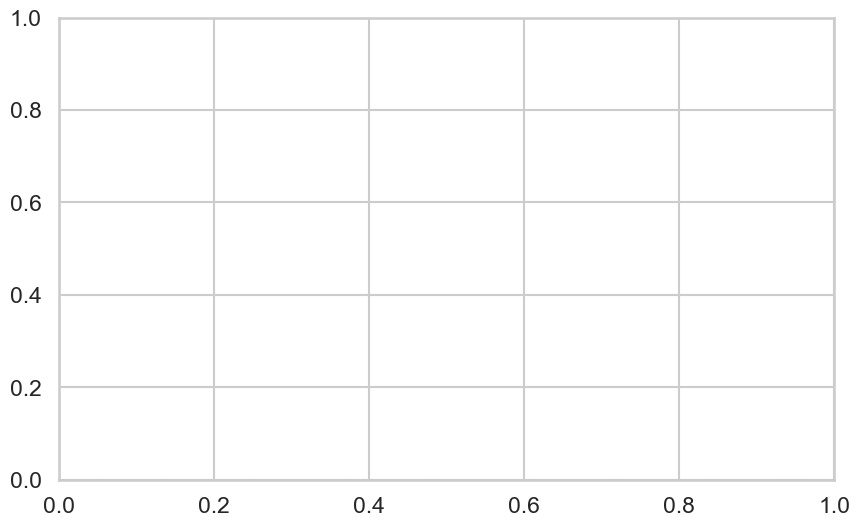

In [6]:
# Plot the differences with a moderate figure width.
plt.figure(figsize=(10, 6))
x_positions = np.arange(len(input_dirs))

# Plot a horizontal reference line at 0.
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# Plot a line for each LLM.
for llm in sorted(diff_scores.keys()):
    diff = diff_scores[llm]
    plt.plot(
        x_positions,
        diff,
        marker="o",
        linewidth=2.5,
        label=llm
    )

# Compute the general trend (average difference across all LLMs for each directory).
trend = []
for i in range(len(input_dirs)):
    values = [diff_scores[llm][i] for llm in diff_scores if not np.isnan(diff_scores[llm][i])]
    trend_val = np.mean(values) if values else np.nan
    trend.append(trend_val)

# Plot the general trend line as a dashed line without markers in a distinct color.
plt.plot(
    x_positions,
    trend,
    linestyle="--",
    linewidth=2,
    color="orange",
    label="General Trend"
)

# Beautify the plot.
plt.xticks(x_positions, ["Baseline", "Antibias", "Antibias Advanced"], fontsize=12)
plt.ylabel("Difference in Mean Score (Confident - Hedged)", fontsize=12)
plt.title("Difference between Confident and Hedged Scores", fontsize=18, y=1.16, fontweight="bold")
plt.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.05, 1.175), framealpha=1)
plt.tight_layout()
plt.savefig("Confident_vs_Hedged_Scores.svg", format="svg", transparent=True)
plt.show()

# Print the average difference for each LLM for each directory.
for llm in sorted(diff_scores.keys()):
    print(f"{llm}: {diff_scores[llm]}")

# Print the general trend values for each directory.
print("General Trend:")
print(trend)

# print the decreases between each pair in percentages

# Compute the percentage decrease across all pairs of directories.
percent_decreases = []
for i in range(1, len(input_dirs)):
    values = [
        100 - ((confident_scores[llm][i] - hedged_scores[llm][i]) / (confident_scores[llm][i - 1] - hedged_scores[llm][i - 1]) * 100)
        for llm in confident_scores
    ]
    
    percent_decreases.append(values)

# Print the percentage decreases for each pair of directories.
for i, values in enumerate(percent_decreases):
    print(f"Percentage Decrease ({input_dirs[i+1]} vs. {input_dirs[i]}):")
    for llm, value in zip(sorted(confident_scores.keys()), values):
        print(f"{llm}: {value:.2f}%")

# do the same for the general trend
general_trend = []
for i in range(1, len(input_dirs)):
    values = [
        100 - (trend[i] / trend[i-1] * 100)
    ]
    general_trend.append(values)

# Print the percentage decreases for the general trend.
for i, values in enumerate(general_trend):
    print(f"Percentage Decrease ({input_dirs[i+1]} vs. {input_dirs[i]}):")
    print(f"{values[0]:.2f}%")

